In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import plotly.express as px
import seaborn as sns
import geopandas
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from xgboost import XGBClassifier
import datetime as dt

pd.options.display.max_columns=None
pd.options.display.max_rows=None

In [74]:
accepted = pd.read_csv('accepted_2007_to_2018Q4.csv.gz')
accepted.head()
accepted.shape

D:\software\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3147: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(2260701, 151)

In [75]:
accepted['date'] = pd.to_datetime(accepted['issue_d'], format='%b-%Y')
accepted['year'] = accepted['date'].dt.year
accepted['month'] = accepted['date'].dt.month

accepted['profit'] = (accepted['total_pymnt']-accepted['loan_amnt'])/accepted['loan_amnt']

In [228]:
model_df=accepted[['loan_amnt','term','int_rate','installment','grade','sub_grade','emp_title','emp_length','home_ownership',\
                   'annual_inc','date','purpose','addr_state','dti','delinq_2yrs','earliest_cr_line','fico_range_low',\
                   'fico_range_high','inq_last_6mths','mths_since_last_delinq','mths_since_last_record','open_acc','pub_rec',\
                   'revol_bal','revol_util','total_acc', 'acc_now_delinq','delinq_amnt', 'mths_since_last_major_derog',\
                   'collections_12_mths_ex_med','application_type','loan_status','year','month','profit']]

model_df = model_df.dropna(how='any', subset=['grade'])
model_df = model_df[model_df['grade'].isin(['E','F','G'])]

# conver loan status to binary (fully paid and defaulted)

model_df.loc[model_df['loan_status']=='Fully Paid','loan_status'] = 0
model_df.loc[model_df['loan_status']=='Does not meet the credit policy. Status:Fully Paid','loan_status'] = 0
model_df.loc[model_df['loan_status']=='Does not meet the credit policy. Status:Charged Off','loan_status'] = 1
model_df.loc[model_df['loan_status']=='Charged Off','loan_status'] = 1
model_df.loc[model_df['loan_status']=='Default','loan_status'] = 1

# conver address state into 8 regions

new_england = ['CT', 'ME', 'MA', 'NH', 'RI', 'VT']
mideast = ['DE', 'DC', 'MD', 'NJ', 'NY', 'PA']
great_lakes = ['IL', 'IN', 'MI', 'OH', 'WI']
plains = ['IA', 'KS', 'MN', 'MO', 'NE', 'ND', 'SD']
south_east = ['AL', 'AR', 'FL', 'GA', 'KY','LA', 'MS', 'NC', 'SC', 'TN', 'VA', 'WV']
south_west = ['AZ','NM','OK','TX']
rocky_mountain = ['CO','ID','MT','UT','WY']
west = ['AK','CA','HI','NV','OR','WA']

def regions(state):
    if state in new_england:
        return 'NewEngland'
    elif state in mideast:
        return 'MidEast'
    elif state in great_lakes:
        return 'GreatLakes'
    elif state in plains:
        return 'Plains'
    elif state in south_east:
        return 'SouthEast'
    elif state in south_west:
        return 'SouthWest'
    elif state in rocky_mountain:
        return 'RockyMountain'
    elif state in west:
        return 'West'
    
model_df['region'] = model_df['addr_state'].apply(regions)




# select observations that interested
model_df = model_df.loc[(model_df['loan_status']==1) | (model_df['loan_status']==0)]


In [110]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135824 entries, 4 to 2260519
Data columns (total 35 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   loan_amnt                    135824 non-null  float64       
 1   term                         135824 non-null  object        
 2   int_rate                     135824 non-null  float64       
 3   installment                  135824 non-null  float64       
 4   grade                        135824 non-null  object        
 5   sub_grade                    135824 non-null  object        
 6   emp_title                    127571 non-null  object        
 7   emp_length                   128336 non-null  object        
 8   home_ownership               135824 non-null  object        
 9   annual_inc                   135824 non-null  float64       
 10  date                         135824 non-null  datetime64[ns]
 11  purpose                  

In [112]:
model_df['application_type'].value_counts()

Individual    132811
Joint App       3013
Name: application_type, dtype: int64

[Text(0.5, 1.0, 'Loan amount distribution')]

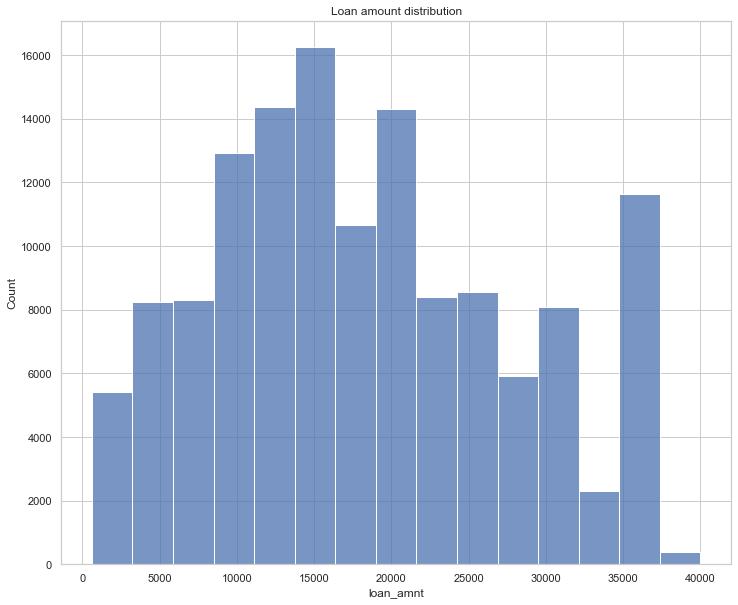

In [151]:
plt.figure(figsize=(12,10))
sns.histplot(model_df,x='loan_amnt',bins=15,).set(title='Loan amount distribution')

[Text(0.5, 1.0, 'Loan amount by grade')]

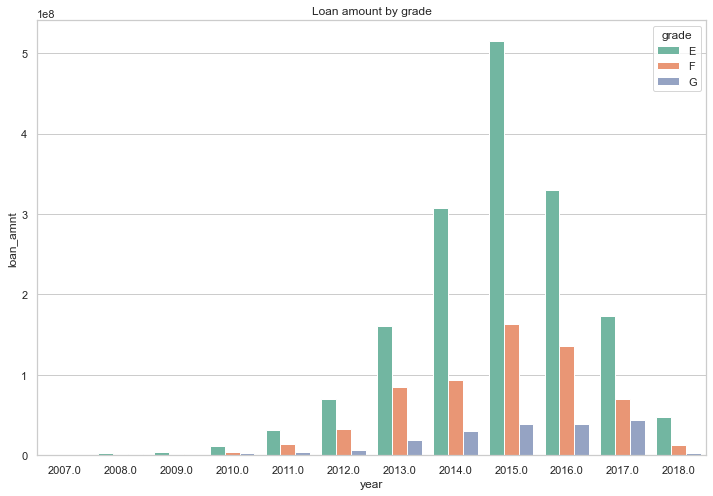

In [78]:
temp = pd.DataFrame(model_df.groupby(['year','grade'])['loan_amnt'].sum().reset_index())
plt.figure(figsize=(12,8))
sns.barplot(data=temp,x='year',y='loan_amnt', hue='grade',palette='Set2').set(title='Loan amount by grade')

<AxesSubplot:xlabel='year', ylabel='loan_amnt'>

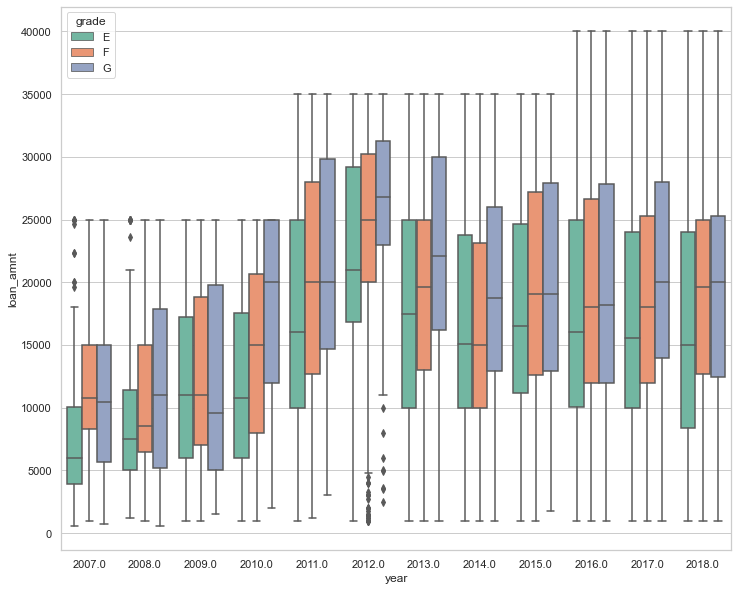

In [99]:
plt.figure(figsize=(12,10))
sns.boxplot(x='year',y='loan_amnt',data=model_df,hue='grade',hue_order=['E','F','G'],palette='Set2')

[Text(0.5, 1.0, 'Profit by Loan Grade')]

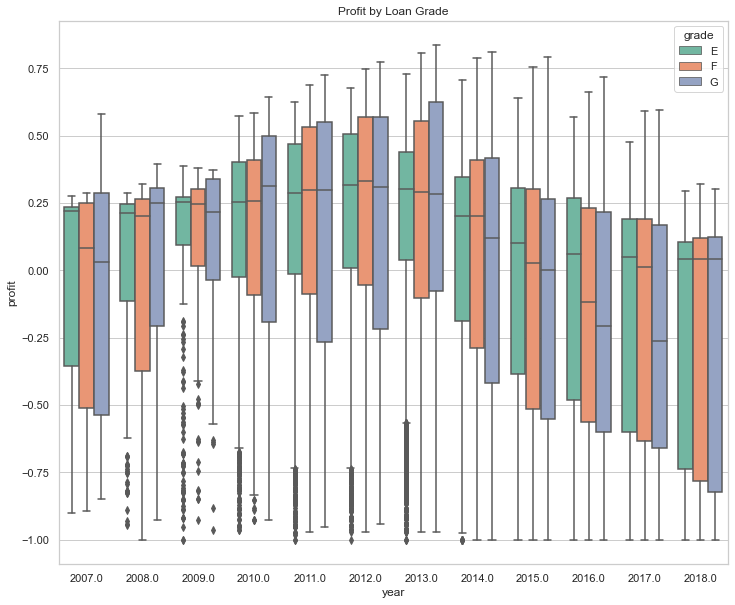

In [101]:
# temp_profit = model_df.groupby(['year','grade'])['profit'].mean().reset_index()
plt.figure(figsize=(12,10))
sns.boxplot(x='year',y='profit',data=model_df,hue='grade',hue_order=['E','F','G'],palette='Set2').set(title='Profit by Loan Grade')

In [115]:
model_df['emp_length'].unique()

array(['3 years', '7 years', '8 years', '4 years', '10+ years', '2 years',
       '6 years', '< 1 year', '1 year', '9 years', nan, '5 years'],
      dtype=object)

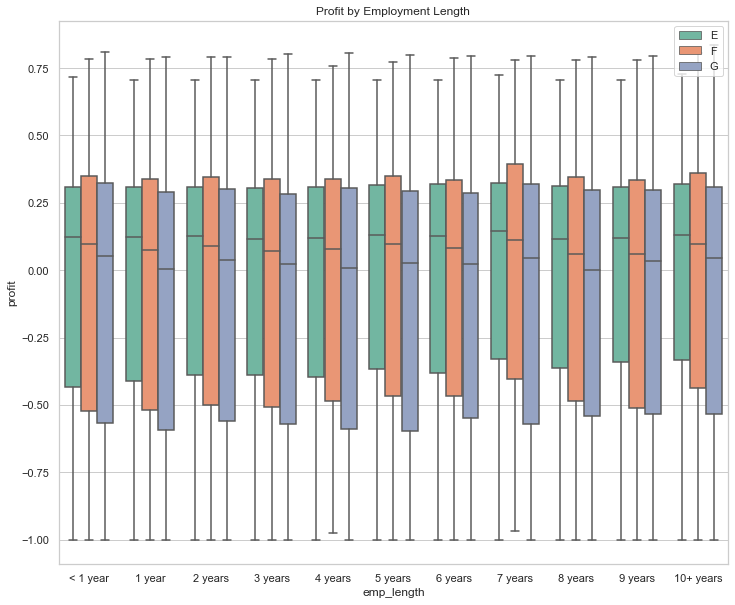

In [123]:
plt.figure(figsize=(12,10))
sns.boxplot(x='emp_length',order=['< 1 year','1 year','2 years','3 years','4 years','5 years','6 years','7 years', '8 years','9 years','10+ years'],y='profit',data=model_df,hue='grade',hue_order=['E','F','G'],palette='Set2').set(title='Profit by Employment Length')
plt.legend(loc='upper right')

[Text(0.5, 1.0, 'Annual Income')]

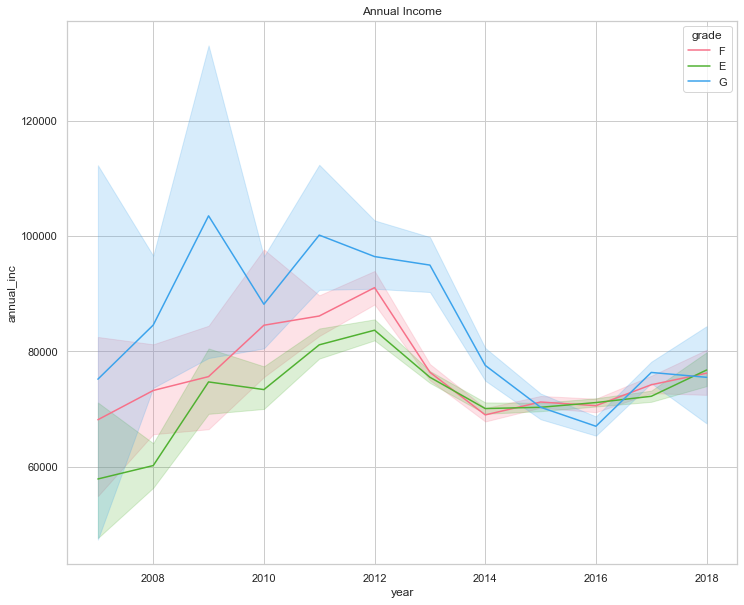

In [125]:
# by_inc = pd.DataFrame(model_df.groupby(['year','grade'])['annual_inc'].mean().reset_index())
plt.figure(figsize=(12,10))
sns.lineplot(data=model_df, x='year',y='annual_inc',hue='grade',palette='husl').set(title='Annual Income')

[Text(0.5, 1.0, 'Annual Income')]

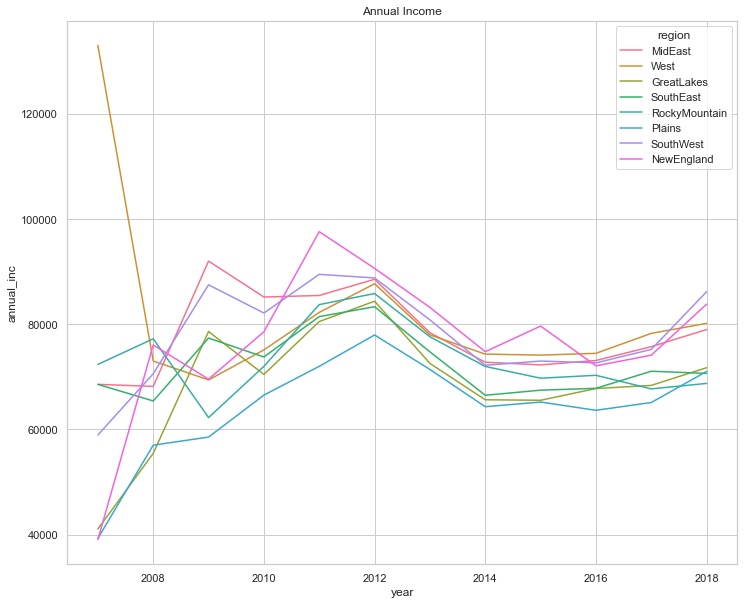

In [230]:
plt.figure(figsize=(12,10))
sns.lineplot(data=model_df, x='year',y='annual_inc',hue='region',palette='husl',err_style=None).set(title='Annual Income')

[Text(0.5, 1.0, 'Annual Income')]

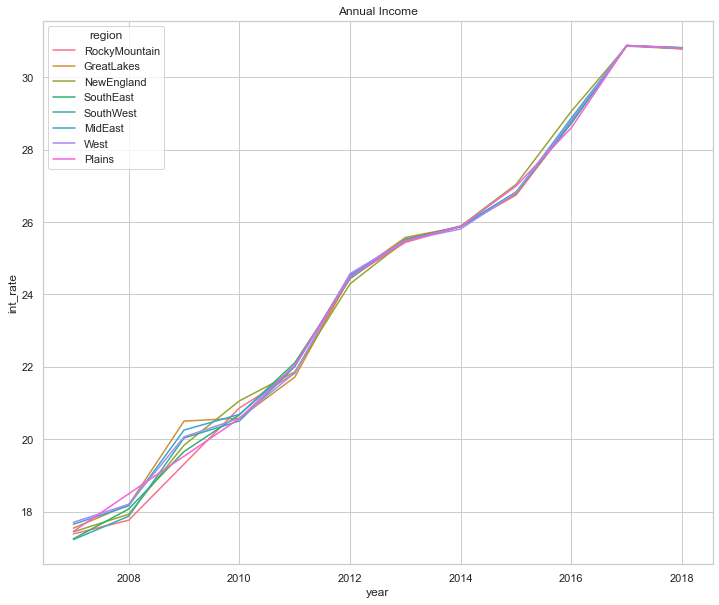

In [234]:
plt.figure(figsize=(12,10))
sns.lineplot(data=model_df.loc[model_df['grade']=='G'], x='year',y='int_rate',hue='region',palette='husl',err_style=None).set(title='Annual Income')

[Text(0.5, 1.0, 'Annual Income')]

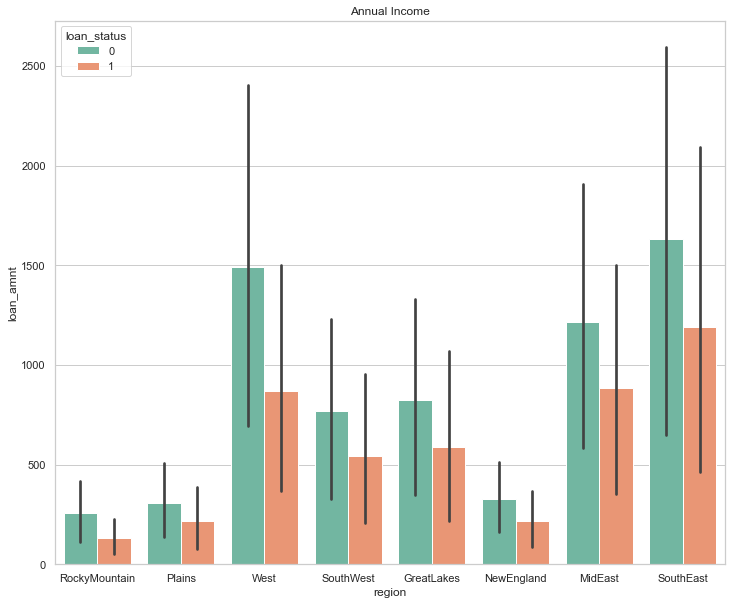

In [241]:
temp_region = pd.DataFrame(model_df.groupby(['year','region','loan_status'])['loan_amnt'].count().sort_values().reset_index())
plt.figure(figsize=(12,10))
sns.barplot(data=temp_region, x='region',y='loan_amnt',hue='loan_status',palette='Set2').set(title='Annual Income')

[Text(0.5, 1.0, 'interest rate')]

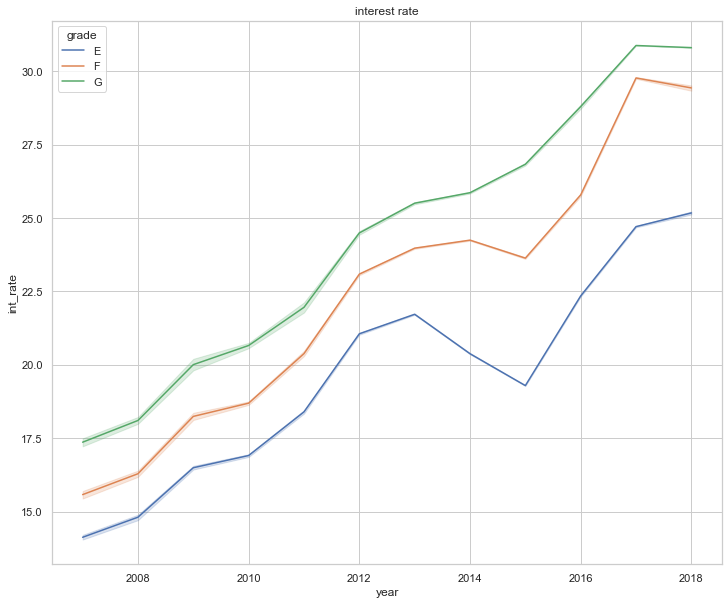

In [227]:
# by_int_rate = pd.DataFrame(model_df.groupby(['year','grade'])['int_rate'].mean().reset_index())
# by_int_rate.head()
plt.figure(figsize=(12,10))
sns.lineplot(data=model_df, x='year',y='int_rate',hue='grade',hue_order=['E','F','G']).set(title='interest rate')

[Text(0.5, 1.0, 'Profit by Loan Grade')]

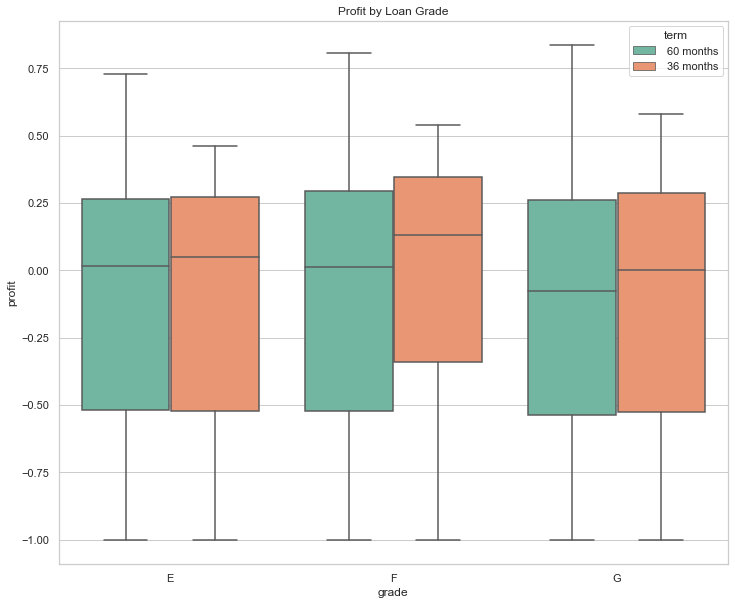

In [63]:
plt.figure(figsize=(12,10))
sns.set_style('whitegrid')
sns.boxplot(x='grade',y='profit',data = model_df,hue='term',order=['E','F','G'],palette='Set2').set(title='Profit by Loan Term')


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 [Text(0, 0, 'educational'),
  Text(1, 0, 'renewable_energy'),
  Text(2, 0, 'wedding'),
  Text(3, 0, 'vacation'),
  Text(4, 0, 'car'),
  Text(5, 0, 'moving'),
  Text(6, 0, 'house'),
  Text(7, 0, 'medical'),
  Text(8, 0, 'major_purchase'),
  Text(9, 0, 'small_business'),
  Text(10, 0, 'home_improvement'),
  Text(11, 0, 'other'),
  Text(12, 0, 'credit_card'),
  Text(13, 0, 'debt_consolidation')])

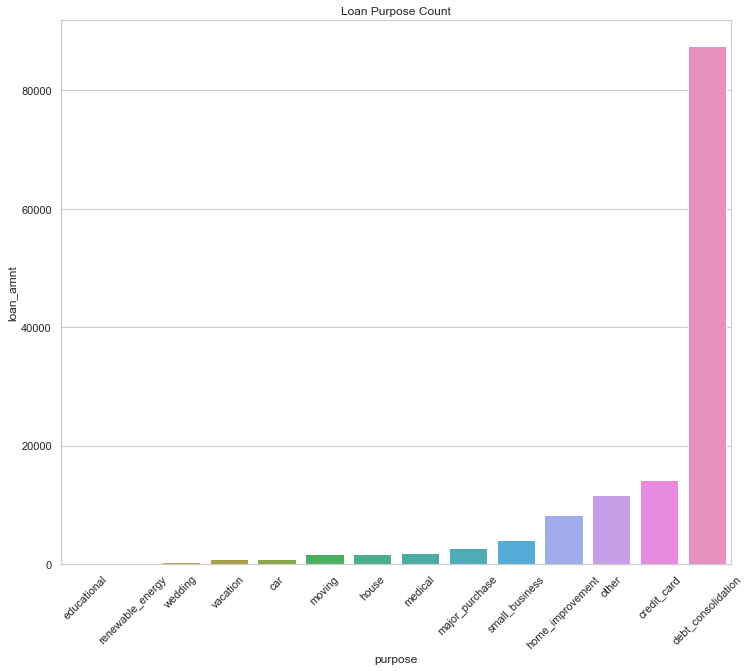

In [150]:
plt.figure(figsize=(12,10))
temp_purpose = pd.DataFrame(model_df.groupby(['purpose'])['loan_amnt'].count().sort_values().reset_index())
sns.barplot(x='purpose',y='loan_amnt',data=temp_purpose).set(title='Loan Purpose Count')
plt.xticks(rotation=45)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 [Text(0, 0, 'major_purchase'),
  Text(1, 0, 'debt_consolidation'),
  Text(2, 0, 'house'),
  Text(3, 0, 'credit_card'),
  Text(4, 0, 'home_improvement'),
  Text(5, 0, 'renewable_energy'),
  Text(6, 0, 'small_business'),
  Text(7, 0, 'car'),
  Text(8, 0, 'medical'),
  Text(9, 0, 'moving'),
  Text(10, 0, 'other'),
  Text(11, 0, 'vacation'),
  Text(12, 0, 'educational'),
  Text(13, 0, 'wedding')])

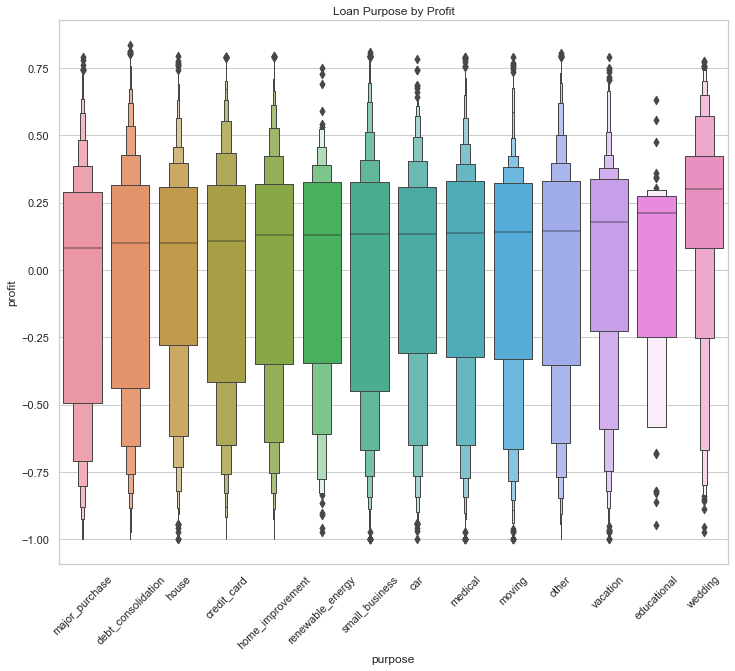

In [95]:
plt.figure(figsize=(12,10))
sns.set_style('whitegrid')
sorted_index = model_df.groupby('purpose')['profit'].median().sort_values().index
sns.boxenplot(x='purpose',y='profit',order=sorted_index,data=model_df).set(title='Profit by Loan Purpose')
plt.xticks(rotation=45)

[Text(0.5, 1.0, 'Profit by Home Ownership')]

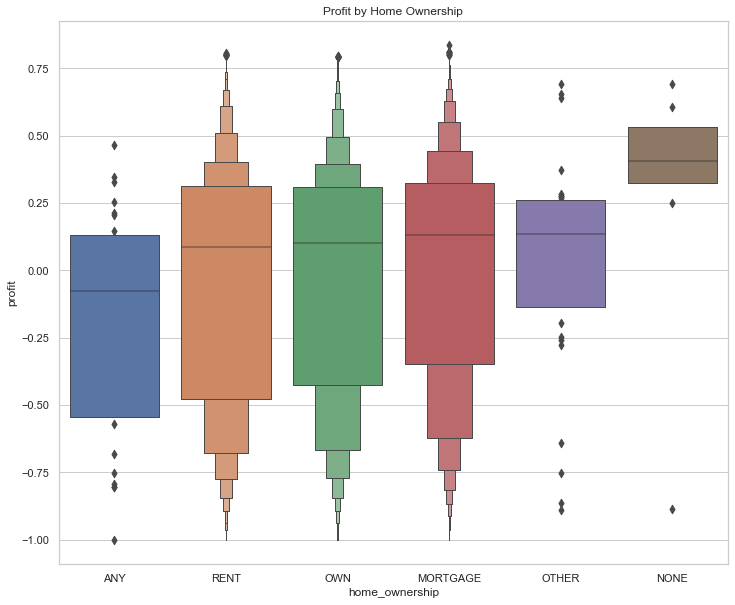

In [106]:
plt.figure(figsize=(12,10))
sns.set_style('whitegrid')
sorted_index = model_df.groupby('home_ownership')['profit'].median().sort_values().index
sns.boxenplot(x='home_ownership',y='profit',order=sorted_index,data=model_df).set(title='Profit by Home Ownership')


In [134]:
model_df.corr()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,acc_now_delinq,delinq_amnt,mths_since_last_major_derog,collections_12_mths_ex_med,year,month,profit
loan_amnt,1.000000,0.080663,0.948015,0.394320,0.004706,0.017082,0.139101,0.139102,-0.046554,-0.019080,0.032958,0.209735,-0.043154,0.309824,0.102625,0.269653,0.005426,-0.000954,0.003820,-0.017229,0.006557,0.011540,-0.027873
int_rate,0.080663,1.000000,0.177835,0.015406,0.055476,0.000975,0.016717,0.016717,-0.000583,0.007243,0.096887,0.029434,0.016880,-0.006171,-0.070257,-0.015883,-0.007677,0.001079,0.009831,0.009703,0.479342,0.011664,-0.136756
installment,0.948015,0.177835,1.000000,0.379373,0.012880,0.019874,0.114241,0.114241,-0.022342,-0.020367,0.014062,0.200091,-0.032276,0.291781,0.082477,0.237851,0.005104,0.000703,0.002146,-0.014465,0.081586,0.003811,-0.041726
annual_inc,0.394320,0.015406,0.379373,1.000000,-0.157478,0.062957,0.040069,0.040069,0.087647,-0.050227,-0.037515,0.160972,0.013105,0.316158,0.053409,0.215456,0.019783,0.009771,-0.040398,-0.004058,-0.030367,0.008527,0.040080
dti,0.004706,0.055476,0.012880,-0.157478,1.000000,-0.031556,0.001829,0.001829,-0.069108,0.033836,0.085830,0.199258,-0.027971,0.109489,0.106233,0.154042,-0.005676,-0.009845,0.051966,-0.008803,0.142943,-0.015722,-0.065121
delinq_2yrs,0.017082,0.000975,0.019874,0.062957,-0.031556,1.000000,-0.118435,-0.118435,0.023362,-0.549882,-0.066524,0.033025,-0.020613,-0.041277,-0.085730,0.128913,0.140864,0.033667,-0.434261,0.072490,0.001665,0.006037,0.006572
fico_range_low,0.139101,0.016717,0.114241,0.040069,0.001829,-0.118435,1.000000,1.000000,-0.033986,0.045838,0.188803,-0.032816,-0.133204,0.029984,-0.300832,-0.046489,-0.026055,-0.010931,0.032662,-0.043625,0.109885,0.010994,-0.017557
fico_range_high,0.139102,0.016717,0.114241,0.040069,0.001829,-0.118435,1.000000,1.000000,-0.033986,0.045838,0.188803,-0.032817,-0.133204,0.029984,-0.300831,-0.046489,-0.026055,-0.010931,0.032662,-0.043625,0.109885,0.010994,-0.017557
inq_last_6mths,-0.046554,-0.000583,-0.022342,0.087647,-0.069108,0.023362,-0.033986,-0.033986,1.000000,0.015296,-0.114166,0.144640,0.064054,-0.010664,-0.152289,0.168440,-0.009532,-0.001369,-0.028946,0.011308,-0.148325,-0.002198,0.001418
mths_since_last_delinq,-0.019080,0.007243,-0.020367,-0.050227,0.033836,-0.549882,0.045838,0.045838,0.015296,1.000000,0.020000,0.006432,0.094100,-0.006496,0.054643,-0.024557,-0.146464,-0.040511,0.696215,-0.043805,0.039332,-0.003626,-0.010070


<AxesSubplot:>

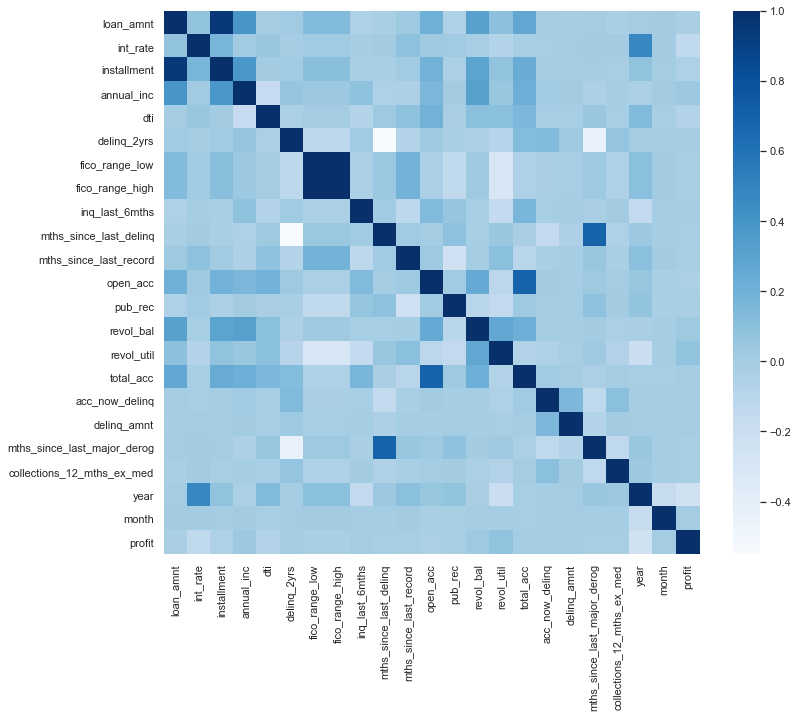

In [136]:
plt.figure(figsize=(12,10))
sns.heatmap(model_df.corr(),cmap='Blues')

In [219]:
import plotly.express as px
temp_sum['loan_status'] = temp_sum['loan_status'].astype('object')
fig = px.bar(temp_sum,x='year',y='loan_amnt',facet_col='grade',color='loan_status',barmode='group')
fig.update_layout(yaxis_title="count",title="Loan Status")
fig.show()

<AxesSubplot:xlabel='loan_status', ylabel='fico_range_low'>

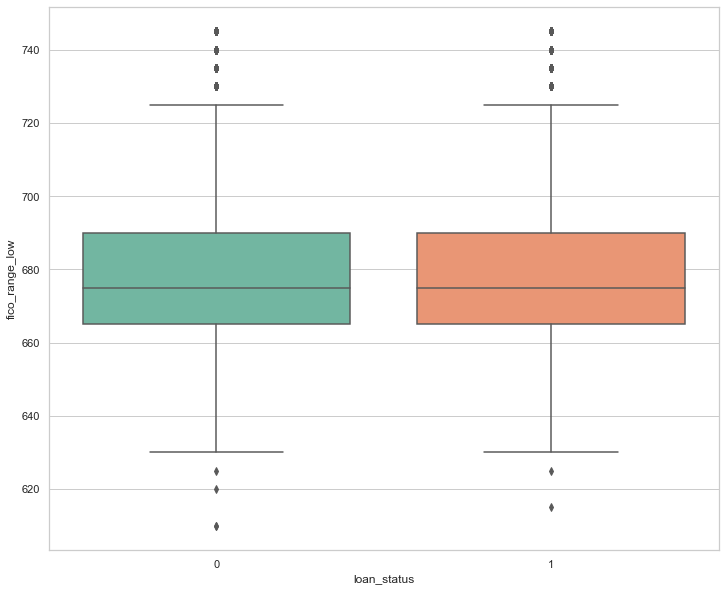

In [222]:
plt.figure(figsize=(12,10))
sns.boxplot(x='loan_status',y='fico_range_low',data=model_df.loc[model_df['fico_range_low']<750,:] ,palette='Set2')

<AxesSubplot:xlabel='loan_status', ylabel='dti'>

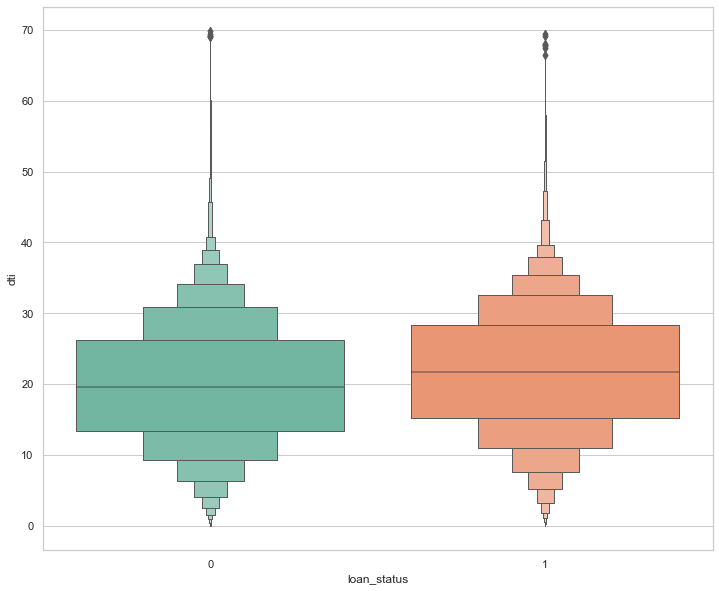

In [223]:
plt.figure(figsize=(12,10))
sns.boxenplot(x='loan_status',y='dti',data=model_df.loc[model_df['dti']<70,:], palette='Set2')

<AxesSubplot:xlabel='loan_status', ylabel='revol_util'>

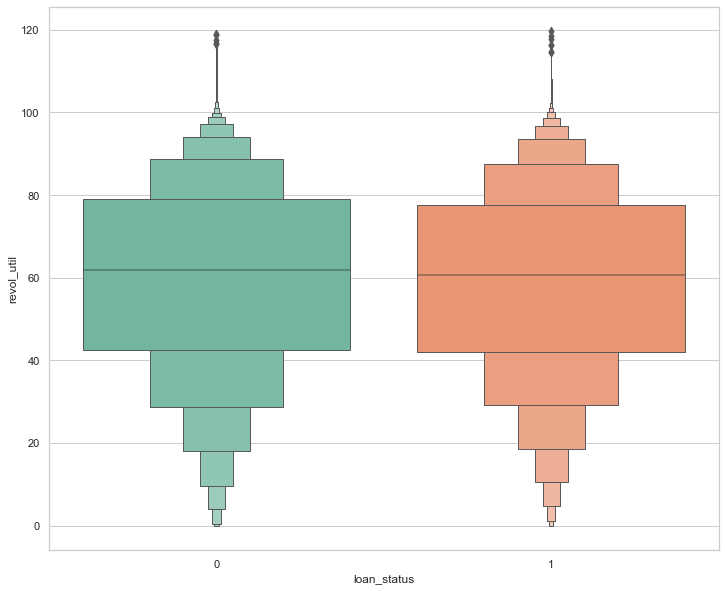

In [224]:
plt.figure(figsize=(12,10))
sns.boxenplot(x='loan_status',y='revol_util',data=model_df.loc[model_df['revol_util']<120,:], palette='Set2')

<AxesSubplot:xlabel='loan_status', ylabel='annual_inc'>

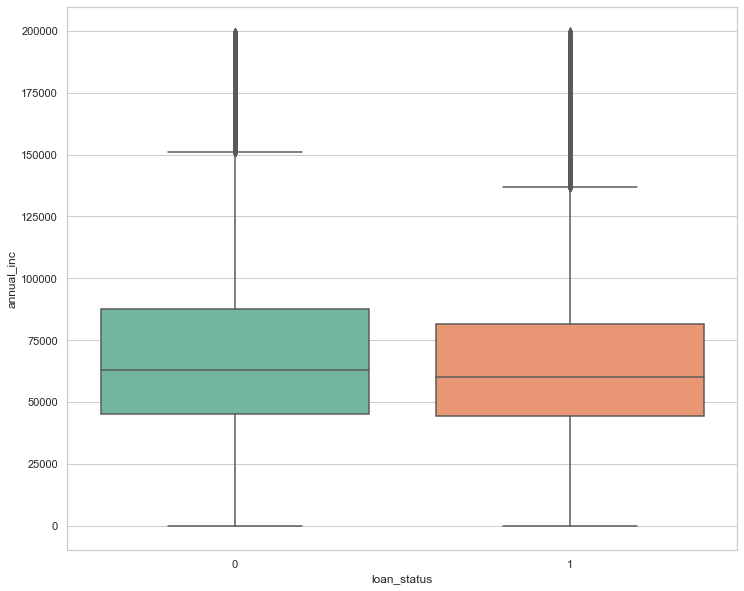

In [225]:
plt.figure(figsize=(12,10))
sns.boxplot(x='loan_status',y='annual_inc',data=model_df.loc[model_df['annual_inc']<2e5,:], palette='Set2')

In [204]:
# cont_features = ['fico_range_low', 'fico_range_high', 'int_rate', 'open_acc', 'annual_inc', 'revol_util', 'revol_bal', 'dti']
# for feature in cont_features:
#     plt.figure(figsize=(12,10))
#     fig = px.box(model_df,x='year',y=feature,facet_col='grade',color='loan_status')
# #     fig.update_layout(yaxis_title="count",title="Loan Status")
#     fig.show()